# LINFA Tutorial
This LINFA tutorial will guide you through using the most common functionalities of LINFA with a hands-on examples.
<br>

* **What is LINFA?**
<br> 
    LINFA is a library for variational inference with normalizing flow and adaptive annealing. LINFA accommodates computationally expensive models and difficult-to-sample posterior distributions with dependent parameters.
    
* **Why should I use LINFA?**
<br>
    Designed as a general inference engine, LINFA allows the user to define custom input transformations, computational models, surrogates, and likelihood functions which will be discussed throughout the tutorial.

### Tutorial outline

In this tutorial we will:

1. Analyze and implement a physics-based model for a ballistic application.

2. Generate a set of synthetic observations.

3. Compute the model gradients using PyTorch and verify their correctness through a finite difference approximation.

4. Perform an inference tasks with LINFA:

    * Case 1: Variational inference with the original model.

    * Case 2: Variational inference with a lightweight neural network surrogate.

After going through this tutorial, you will be able to integrate you favorite physics-based model with LINFA, to perform inference tasks.
<br>

In addition, we emphasize two special features available through LINFA:

* Adaptively trained surrogate models (NoFAS module).

* Adaptive annealing schedulers (AdaAnn module).

We encourage the user to take advantage of such features, especially when using physics-based models with computationally expensive evaluations. 

### Additional Resources

#### Background theory and examples for LINFA

* Y. Wang, E.R. Cobian, J. Lee, F. Liu, J.D. Hauenstein, D.E. Schiavazzi, [LINFA: a Python library for variational inference with normalizing flow and annealing](https://arxiv.org/abs/2307.04675)

* Y. Wang, F. Liu and D.E. Schiavazzi, [Variational Inference with NoFAS: Normalizing Flow with Adaptive Surrogate for Computationally Expensive Models](https://www.sciencedirect.com/science/article/abs/pii/S0021999122005162)

* E.R. Cobian, J.D. Hauenstein, F. Liu and D.E. Schiavazzi, [AdaAnn: Adaptive Annealing Scheduler for Probability Density Approximation](https://www.dl.begellhouse.com/journals/52034eb04b657aea,796f39cb1acf1296,6f85fe1149ff41d9.html?sgstd=1)

#### More about LINFA library: 

* LINFA library [documentation](https://linfa-vi.readthedocs.io/en/latest/index.html)

* LINFA GitHub [repository](https://github.com/desResLab/LINFA)

In [1]:
! pip install linfa-vi

In [2]:
## Import libraries ##
import os
import linfa
from linfa.run_experiment import experiment
from linfa.transform import Transformation
from linfa.nofas import Surrogate
import torch
import random
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt


### Problem definition
* Our physics-based model **phys** consists of a simple ballistic model. It computes the outputs: 
    * maximum height (m) $x_{1}$,
    * final landing location (m) of the object $x_{2}$,
    * total flight time (s)  $x_{2}$,
    
    from the inputs:
    * starting position (m) $z_{1}$,
    * initial velocity (m/s)  $z_{2}$,
    * angle (degrees) $z_{3}$.
<br>

The model is described by the following equations
$$
x_{1} = \frac{z_{2}^{2}\,\sin^{2}(z_{3})}{2\,g},\,\,
x_{2} = z_{1} + \frac{z_{2}^{2}\,\sin(2\,z_{3})}{g},\,\,
x_{3} = \frac{2\,z_{2}\,\sin(z_{3})}{g}.
$$

#### Model identifiability

By considering fixed values for the outputs $(x_{1},x_{2},x_{3}) = (\widetilde{x}_{1},\widetilde{x}_{2},\widetilde{x}_{3})$, we can perform some algebraic manipulation to investigate structural identifiability. For example, if we derive $z_{2}$ from the equation for $x_{3}$ and we plug it back in the equation for $x_{1}$, we get the equation
$$
g\,\frac{\widetilde{x}_{3}^{2}}{8} = \widetilde{x}_{1}^{2}.
$$

The maximum height and time of flight are, as expected, related by a deterministic condition and therefore only one of these provide an independent information for the solution of the inverse problem. 

Due to this dependence, the number of observables is reduced to only two, from three inputs. This results in a non-identifiable inference task. In other words, there is an infinite number of input combinations $(z_{1},z_{2},z_{3})$ corresponding to the outputs $(\widetilde{x}_{1},\widetilde{x}_{2},\widetilde{x}_{3})$. 

A graphical explanation for this lack of identifiability can be is shown in the the plot below

<img src="imgs/trajectories.png" width="800px" aligned="center"><br>
**Figure:** Examples of trajectories resulting in the same landing distance and maximum height (or time of flight).

This picture shows how the final target location at $x_{2}$ can be reached by multiple initial positions, velocities and angles. The lack of identifiability also translates in the existence of a one-dimensional manifold of inputs that correspond to the same outputs. This manifold can be determined from the following expressions in the form $z_1(z_{3})$ and $z_2(z_{3})$ 
$$
z_{1} = \widetilde{x}_{2} - \frac{g\cdot \widetilde{x}_{3}^{2}}{2}\cdot \left[\frac{\cos(z_{3})}{\sin(z_{3})}\right],\,\,
z_{2} = \frac{g\cdot \widetilde{x}_{3}}{2\,\sin(z_{3})}.
$$
These two curves are plotted below.

<img src="imgs/non_ident.png" width="800px" aligned="center"><br>
**Figure:** Two-dimensional projections of one-dimensional manifold where all parameters correspond to the same outputs. When performing inference we therefore expect the posterior distribution to be concentrated around such curves. 

#### Implementation as a Python class

* We first create a new **Phys** model class, having three member functions:

    * `__init__` - A constructor.

    * `genDataFile` - A member function to create synthetic observations.

    * `solve_t` - A function to perform forward model evaluations.

*Please refer to the comments below for additional implementation details.* 

In [3]:
#### Implementation of the traditional trajectory motion physics problem ####
class Phys:
    
    ### Define constructor function for Phys class ###
    def __init__(self):
        ## Define input parameters (True value)  
        # input[] = [starting_position, initial_velocity, angle] = [1(m), 5(m/s), 60(degs)]
        self.defParam = torch.Tensor([[1.0, 5.0, 60.0]])

        self.gConst = 9.81   # gravitational constant
        self.stdRatio = 0.05 # standard deviation ratio
        self.data = None     # data set of model sample

    ### Define data file generator function ###
    # dataSize (int): size of sample (data)
    # dataFileName (String): name of the sample data file
    # store (Boolean): True if user wish to store the generated data file; False otherwise.
    def genDataFile(self, dataSize = 50, dataFileName="data_phys_3d.txt", store=True):
        def_out = self.solve_t(self.defParam)[0]
        self.data = def_out + self.stdRatio * torch.abs(def_out) * torch.normal(0, 1, size=(dataSize, 3))
        self.data = self.data.t().detach().numpy()
        if store: np.savetxt(dataFileName, self.data)
        return self.data

    ### Define data file generator function ###
    # params (Tensor): input parameters storing starting position, initial velocity, and angle in corresponding order.
    def solve_t(self, params):
        z1, z2, z3 = torch.chunk(params, chunks=3, dim=1) # input parameters
        z3 = z3 * (np.pi / 180)                           # convert unit from degree to radians
        
        ## Output value calculation
        # ouput[] = [maximum_height, final_location, total_time]
        x = torch.cat(( (z2 * z2 * torch.sin(z3) * torch.sin(z3)) / (2.0 * self.gConst),  # x1: maxHeight
            z1 + ((z2 * z2 * torch.sin(2.0 * z3)) / self.gConst),                         # x2: finalLocation 
            (2.0 * z2 * torch.sin(z3)) / self.gConst), 1)                                 # x3: totalTime
        return x

### Generation of synthetic data

The *genDataFile* member function is designed to generate multiple synthetic outputs by adding Gaussian noise around the output corresponding to a *default parameter set* 
$$\boldsymbol{z}^{*} = (1.0, 5.0, 60.0)$$
where the initial angle of the trajectory is measured in degrees. The following code generates 50 synthetic observations and stores them in the *data_phys.txt* file. 

In [4]:
## Generate phys sample file ##
# Define model
model = Phys()
# Generate Data
physData = model.genDataFile()

Now that we have our model set up, we go on to our second step and check the computation of its gradient.

### Check for Gradient Calculation

* Prior to applying NoFAS to our **Phys** model, we check if the model gradient (Jacobian actually since it has multiple outputs) is correctly computed by PyTorch. 

* Specifically, when the surrogate is not enabled, gradient calculation is completed straight through the model, so we want to ensure that this is correct before running an inference task.

* Here we compute each gradient using (1) Pytorch and (2) a forward Euler finite difference approximation, and compare the results provided by these two approaches.

 #### Computing gradients through PyTorch

 We define a new class to compute gradients. The class is construced by specifying a model and a transformation and provides member functions to compute the derivatives.

In [5]:
#### Implementation of gradient calculation using PyTorch - version 2 #### 
class PytorchGrad: 
    
    ### Define constructor function for PytorchGrad2 class ###
    def __init__(self, model, transform):
        # Define input parameters and enable gradient calculation
        self.z = torch.Tensor([[1.0, 5.0, 60.0]])
        self.z.requires_grad = True
        
        self.in_vals = transform.forward(self.z)

        self.out_val = model.solve_t(self.in_vals)
        self.out1, self.out2, self.out3 = torch.chunk(self.out_val, chunks=3, dim=1)

    # Compute gradients using backward function for y
    def back_x1(self): 
        self.out1.backward()
        d1 = self.z.grad
        a, b, c = torch.chunk(d1, chunks=3, dim=1)
        return [a.item(), b.item(), c.item()]
    
    def back_x2(self): 
        self.out2.backward()
        d2 = self.z.grad
        a, b, c = torch.chunk(d2, chunks=3, dim=1)
        return [a.item(), b.item(), c.item()]
    
    def back_x3(self): 
        self.out3.backward()
        d3 = self.z.grad
        a, b, c = torch.chunk(d3, chunks=3, dim=1)
        return [a.item(), b.item(), c.item()]
        

We then use the class with the **Phys** model and an *identity* transformation as shown next.

In [6]:
# Define Phys model
model = Phys()

# Set transformation information and define transforamtion
trsf_info = [['identity',0.0,0.0,0.0,0.0],
             ['identity',0,0.0,0.0,0.0],
             ['identity',0,0.0,0.0,0.0]]
        
transform = Transformation(trsf_info)

# List to store dx/dz values
dx_dz_pytorch = []

# Define PytorchGrad object and calculate gradient
pyGrad = PytorchGrad(model, transform)
dx_dz_pytorch.append(pyGrad.back_x1())

pyGrad = PytorchGrad(model, transform)
dx_dz_pytorch.append(pyGrad.back_x2())

pyGrad = PytorchGrad(model, transform)
dx_dz_pytorch.append(pyGrad.back_x3())

# convert to pandas DataFrame for readability
jacob_mat_2 = pd.DataFrame(dx_dz_pytorch, columns=['dz1', 'dz2', 'dz3'])
jacob_mat_2.index = ['dx1', 'dx2', 'dx3']
jacob_mat_2

,dz1,dz2,dz3
dx1,0.0,0.382263,0.019260
dx2,1.0,0.882799,-0.044478
dx3,0.0,0.176560,0.008896


#### Approximating gradients with finite differences

We now apply the forward Euler approximation of the gradient to verify the results above. 

In [7]:
### Function that manually calculates a derivative ###
def getGrad(f_eps, f, eps):
    return (f_eps - f) / (eps)

### Function that returns a list of gradients ###
def gradList(f_eps1, f_eps2, f_eps3, f, eps): 
    return [getGrad(f_eps1, f, eps).item(), getGrad(f_eps2, f, eps).item(), getGrad(f_eps3, f, eps).item()]

In [8]:
# List to store dx/dz values
dx_dz = []
dx1_dz = []
dx2_dz = []
dx3_dz = []

# Set up parameters
eps = 1.0
z = torch.Tensor([[1.0, 5.0, 60.0]])
z_eps1 = torch.Tensor([[1.0 + eps, 5.0, 60.0]])
z_eps2 = torch.Tensor([[1.0, 5.0 + eps, 60.0]])
z_eps3 = torch.Tensor([[1.0, 5.0, 60.0 + eps]])

x1_eps1 = model.solve_t(z_eps1)[0,0]
x1_eps2 = model.solve_t(z_eps2)[0,0]
x1_eps3 = model.solve_t(z_eps3)[0,0]
x1_eps = model.solve_t(z)[0,0]

dx1_dz = gradList(x1_eps1, x1_eps2, x1_eps3, x1_eps, eps)
dx_dz.append(dx1_dz)

x2_eps1 = model.solve_t(z_eps1)[0,1]
x2_eps2 = model.solve_t(z_eps2)[0,1]
x2_eps3 = model.solve_t(z_eps3)[0,1]
x2_eps = model.solve_t(z)[0,1]

dx2_dz = gradList(x2_eps1, x2_eps2, x2_eps3, x2_eps, eps)
dx_dz.append(dx2_dz)

x3_eps1 = model.solve_t(z_eps1)[0,2]
x3_eps2 = model.solve_t(z_eps2)[0,2]
x3_eps3 = model.solve_t(z_eps3)[0,2]
x3_eps = model.solve_t(z)[0,2]

dx3_dz = gradList(x3_eps1, x3_eps2, x3_eps3, x3_eps, eps)
dx_dz.append(dx3_dz)

# convert to pandas DataFrame for readability
jacob_mat_3 = pd.DataFrame(dx_dz, columns=['dz1', 'dz2', 'dz3'])
jacob_mat_3.index = ['dx1', 'dx2', 'dx3']
jacob_mat_3

,dz1,dz2,dz3
dx1,0.0,0.420489,0.019062
dx2,1.0,0.971078,-0.045814
dx3,0.0,0.176560,0.008761


#### Check the convergence of the finite difference approximation to the gradient

- *Note*: if you'd like you can adjust the script below to check convergence for other components.

In [9]:
## Focus: dx2_dz3

initial_eps = 15        # Initial change of value (eps)
k = 150                 # Number of iterations
dx2_dz3_list = []       # List to store results
pytorch_grad2 = -0.0445 # Pytorch gradient value

# Calculate for dx2_dz3 as eps decreases
for t in range(1, k):
    update_eps = initial_eps*(1/t)                             # updated eps value
    z_eps3 = torch.Tensor([[1.0, 5.0, 60.0 + update_eps]])     # update z_eps3
    x2_eps3 = model.solve_t(z_eps3)[0,1]                       # update x2_eps3
    dx2_dz3_list.append(getGrad(x2_eps3, x2_eps, update_eps))  # store result to dx2_dz3_list

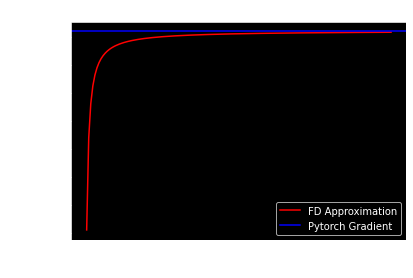

In [10]:
## Plot result to see convergence
plt.style.use('dark_background')

fig, ax = plt.subplots()
ax.plot(range(1,k), dx2_dz3_list, c = "red", linestyle = "solid", label = "FD Approximation")

plt.axhline(y = pytorch_grad2, color = 'blue', linestyle = '-', label = "Pytorch Gradient")
plt.legend(loc="lower right")
plt.title("Gradient Plot for dx2_dz3")
plt.ylabel("Gradient")
plt.xlabel("k-Iterations")
plt.show()

Now that we confirmed that our model successfully computes the gradients, we go on to our third step: *Model Evaluation Set Up and Applications*

### Variational inference with full model

#### Definition of hyperparameters
The first step is to define all options and hyperparameters for the inference task. Additional detail for each hyperparameter can be found in the [documentation](https://linfa-vi.readthedocs.io/en/latest/content/linfa_options.html) or in the definition of the [experiment](https://github.com/desResLab/LINFA/blob/master/linfa/run_experiment.py) class.

In [11]:
# Experiment Setting
exp = experiment()
exp.flow_type        = 'maf'        # str: Type of flow
exp.n_blocks         = 5            # int: Number of layers                            
exp.hidden_size      = 100          # int: Hidden layer size for MADE in each layer  
exp.n_hidden         = 1            # int: Number of hidden layers in each MADE      
exp.activation_fn    = 'relu'       # str: Actication function used                  
exp.input_order      = 'sequential' # str: Input order for create_mask           
exp.batch_norm_order = True         # boolean: Order to decide if batch_norm is used    
exp.save_interval    = 5000         # int: How often to sample from normalizing flow

exp.input_size    = 3               # int: Dimensionality of input                   
exp.batch_size    = 250             # int: Number of samples generated             
exp.true_data_num = 2               # double: number of true model evaluated      
exp.n_iter        = 25001           # int: Number of iterations                      
exp.lr            = 0.01            # float: Learning rate                              
exp.lr_decay      = 0.9999          # float: Learning rate decay                
exp.log_interval  = 100             # int: How often to show loss stat   

exp.run_nofas          = False      # boolean: to run experiment with nofas
exp.annealing          = False      # boolean: to run experiment with annealing
exp.calibrate_interval = 1000       # int: How often to update surrogate model     
exp.budget             = 260        # int: Total number of true model evaluation

exp.surr_pre_it  = 20000            # int: Number of pre-training iterations for surrogate model
exp.surr_upd_it  = 6000             # int: Number of iterations for the surrogate model update
exp.surr_folder  = "./"
exp.use_new_surr = True             # boolean: to run experiment with nofas

exp.results_file = 'results.txt'      # str: result text file name
exp.log_file     = 'log.txt'          # str: log text file name
exp.samples_file = 'samples.txt'      # str: sample text file name
exp.seed         = random.randint(0, 10 ** 9)  # int: Random seed used
exp.n_sample     = 5000               # int: Total number of iterations
exp.no_cuda      = True               # boolean: to run experiment with NO cuda

exp.optimizer    = 'RMSprop'          # str: Type of optimizer
exp.lr_scheduler = 'ExponentialLR'    # str: Type of scheduler

exp.device = torch.device('cuda:0' if torch.cuda.is_available() and not exp.no_cuda else 'cpu')

#### Define the transformation 
Now we define the trasformation of parameters and initialize the 

In [12]:
# Define transformation based on normalization rate
trsf_info = [['identity',0.0,0.0,0.0,0.0],
             ['identity',0.0,0.0,0.0,0.0],
             ['linear',-3,3,40.0,140.0]]
trsf = Transformation(trsf_info)        
exp.transform = trsf

#### Model and surrogate definition
We create an instance of the **Phys** model and assign `None` to the surrogate. Note that we have also specified `exp.run_nofas = False` and `exp.annealing = False` to switch off both the adaptive surrogate capability and annealing. 

In [13]:
# Define model
model = Phys()
exp.model = model

# Get data
model.data = np.loadtxt('./data_phys_3d.txt')

# Run experiment without surrogate
exp.surrogate = None

#### Log-likelihood definiton


In [14]:
## Define log density
# x: original, untransformed inputs
# model: our model
# transform: our transformation 
def log_density(x, model, surrogate, transform):

    # Compute transformation log Jacobian
    adjust = transform.compute_log_jacob_func(x)

    # Get the absolute values of the standard deviations
    stds = torch.abs(model.solve_t(model.defParam)) * model.stdRatio
    Data = torch.tensor(model.data).to(exp.device)
    
    # Check for surrogate
    if surrogate:
        modelOut = exp.surrogate.forward(x)
    else:
        modelOut = model.solve_t(transform.forward(x))

    # Eval LL
    ll1 = -0.5 * np.prod(model.data.shape) * np.log(2.0 * np.pi)
    ll2 = (-0.5 * model.data.shape[1] * torch.log(torch.prod(stds))).item()
    ll3 = 0.0
    for i in range(3):
        ll3 += - 0.5 * torch.sum(((modelOut[:, i].unsqueeze(1) - Data[i, :].unsqueeze(0)) / stds[0, i]) ** 2, dim=1)
    negLL = -(ll1 + ll2 + ll3)
    res = -negLL.reshape(x.size(0), 1) + adjust
    
    return res

#### Launch inference task

In [15]:
## Run 
print('')
print('--- TUTORIAL: Ballistic Example - Full model')

# Experiment Setting
exp.name = "phys_full_3d"             # str: Name of experiment
exp.output_dir   = './' + exp.name    # str: output directory location

# Assign logdensity
exp.model_logdensity = lambda x: log_density(x, model, exp.surrogate, trsf)

# Run VI
exp.run()


--- TUTORIAL: Ballistic Example - Full model

--- Running on device: cpu

VI NF (t=1.000): it:     100 | loss: 9.888e+03
VI NF (t=1.000): it:     200 | loss: 4.040e+03
VI NF (t=1.000): it:     300 | loss: 7.229e+02
VI NF (t=1.000): it:     400 | loss: 4.176e+02
VI NF (t=1.000): it:     500 | loss: 2.605e+02
VI NF (t=1.000): it:     600 | loss: 3.275e+02
VI NF (t=1.000): it:     700 | loss: 2.749e+02
VI NF (t=1.000): it:     800 | loss: 4.634e+02
VI NF (t=1.000): it:     900 | loss: 2.928e+02
VI NF (t=1.000): it:    1000 | loss: 1.815e+02
VI NF (t=1.000): it:    1100 | loss: 1.633e+02
VI NF (t=1.000): it:    1200 | loss: 2.868e+02
VI NF (t=1.000): it:    1300 | loss: 1.306e+02
VI NF (t=1.000): it:    1400 | loss: 2.091e+02
VI NF (t=1.000): it:    1500 | loss: 1.541e+02
VI NF (t=1.000): it:    1600 | loss: 1.281e+02
VI NF (t=1.000): it:    1700 | loss: 1.794e+02
VI NF (t=1.000): it:    1800 | loss: 1.748e+02
VI NF (t=1.000): it:    1900 | loss: 1.770e+02
VI NF (t=1.000): it:    2000 | l

Notice that the model evaluation has been successfully completed by checking at the newly created **phys_nofasFree** folder in the tutorial directory.

Note also that LINFA supports a post processing script to plot the mnain results including the loss profile, two-dimensional slices of the posterior distribution and two-dimensional slices for the predictive posterior.

We can use the command below to generate the result plots

In [16]:
import linfa
! python3 -m linfa.plot_res -n phys_full_3d -i 25000 -f "./" -p 'png' -d

Plotting log...
Plotting posterior samples...
Plotting posterior predictive samples...


You can now visualize the results

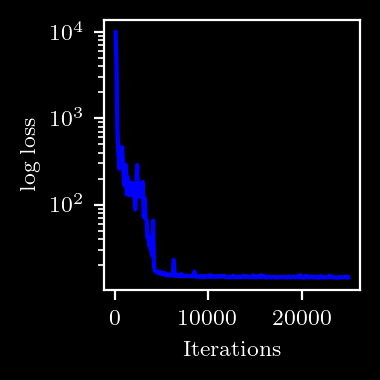

In [17]:
from IPython.display import Image, display
display(Image(filename='./phys_full_3d/log_plot.png',width=300))

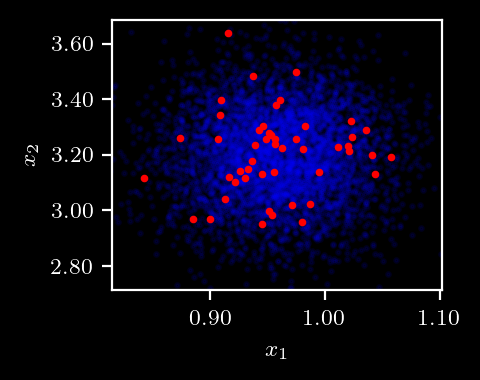

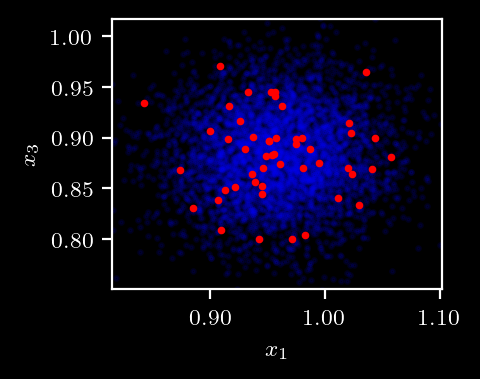

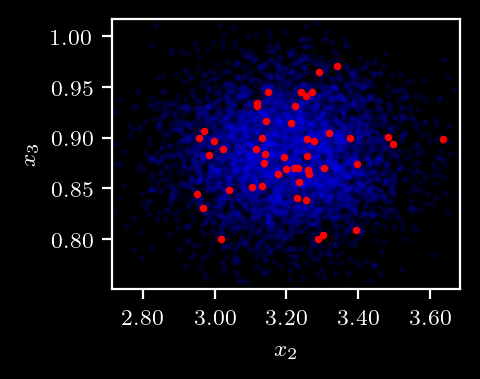

In [18]:
from IPython.display import Image, display
display(Image(filename='phys_full_3d/data_plot_phys_full_3d_25000_0_1.png',width=300))
display(Image(filename='phys_full_3d/data_plot_phys_full_3d_25000_0_2.png',width=300))
display(Image(filename='phys_full_3d/data_plot_phys_full_3d_25000_1_2.png',width=300))

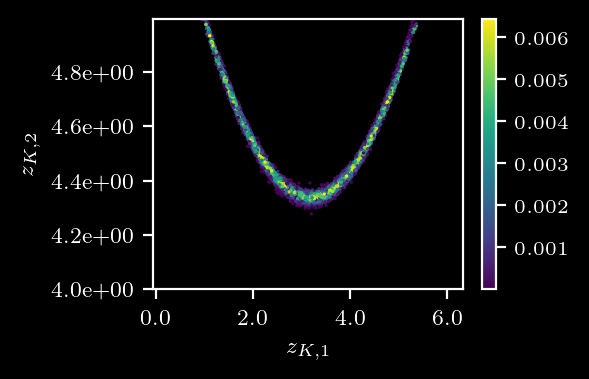

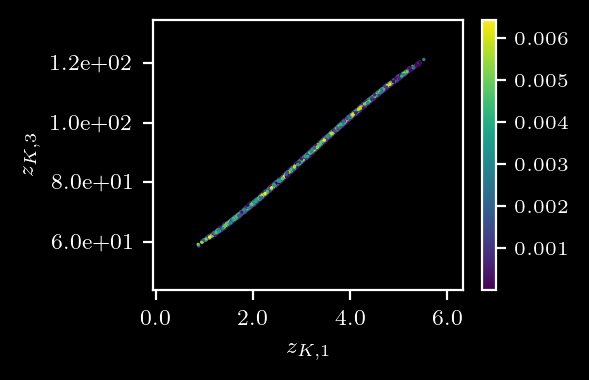

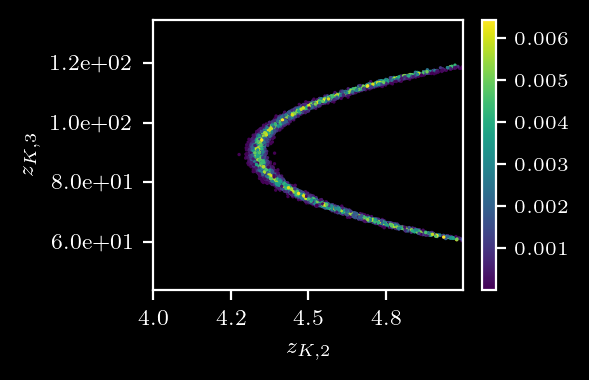

In [19]:
from IPython.display import Image, display
display(Image(filename='phys_full_3d/params_plot_phys_full_3d_25000_0_1.png',width=300))
display(Image(filename='phys_full_3d/params_plot_phys_full_3d_25000_0_2.png',width=300))
display(Image(filename='phys_full_3d/params_plot_phys_full_3d_25000_1_2.png',width=300))

The results look as expected, concentrated around the *fibers* identified above.

However, even with our simple model, the cost of evaluating the physics-based model and to compute the gradient through it can be significant and might lead to intractable inference tasks.

In such cases, LINFA enables the construction of the adaptively trained surrogate model. By utilizing the surrogate model, gradient computation is executed through the surrogate, reducing the computational burden of such operation.

In addition, LINFA provides an adaptive annealing scheduler (AdaAnn) which allows easier sampling from complicated densities.

Accordingly, we will specifically observe how the adaptively trained surrogate model reduces the computational cost in our last step: <br>
*Applying our model including the Surrogate model.*

### AdaAnn: An adaptive annealing scheduler

We start by additing some options to activate the adaptive annealing scheduler and specify the associated hyperparameters.

In [41]:
exp.annealing = True
exp.scheduler = 'AdaAnn' # str: type of annealing scheduler used
exp.tol       = 0.01     # float: tolerance for AdaAnn scheduler
exp.t0        = 0.001    # float: initial inverse temperature value
exp.N         = 250      # int: number of sample points during annealing
exp.N_1       = 250      # int: number of sample points at t=1
exp.T_0       = 500      # int: number of parameter updates at initial t0
exp.T         = 10       # int: number of parameter updates during annealing
exp.T_1       = 25000    # int: number of parameter updates at t=1
exp.M         = 1000     # int: number of sample points used to update temperature

### NoFAS: Normalizing flow with an adaptively trained surrogate

Before specifying a surrogate model, we define the associated hyperparameters. 

In [42]:
exp.run_nofas          = True       # boolean: to run experiment with nofas
exp.calibrate_interval = 2000       # int: How often to update surrogate model     
exp.budget             = 2000       # int: Total number of true model evaluation
exp.surr_pre_it        = 40000      # int: Number of pre-training iterations for surrogate model
exp.surr_upd_it        = 6000       # int: Number of iterations for the surrogate model update
exp.use_new_surr       = True       # boolean: to run experiment with nofas
exp.surr_folder        = "./"
exp.true_data_num      = 15

In addition we need to define the new surrogate and assign the surrogate so the current instance of th *Experiment* class knows about it. 
Note the following hyperparameter choices:

* The `memory_len` parameter is set to 100 to use the adaptively collected samples for a larger number of iterations. 

* A parametric architecture can be specified for the default dense neural network surrogate. The parameter `architednn_arch=[64,32]` is used to generate a dense neural network with two hidden layers having 64 and 32 neurons, respectively. The parameter `dnn_activation='tanh'` is used to specify a `tanh` activation function for all layers except the last.

In [43]:
exp.name = "phys_surr_3d"
exp.output_dir   = './' + exp.name

exp.surrogate = Surrogate(exp.name, lambda x: model.solve_t(trsf.forward(x)), exp.input_size, 3, 
                            model_folder=exp.surr_folder, limits=torch.Tensor([[0, 6], [4, 5], [-3, 3]]), 
                            memory_len=50, dnn_arch=[64,32], dnn_activation='silu', device=exp.device)
surr_filename = exp.surr_folder + exp.name
if exp.use_new_surr or (not os.path.isfile(surr_filename + ".sur")) or (not os.path.isfile(surr_filename + ".npz")):
    print("Warning: Surrogate model files: {0}.npz and {0}.npz could not be found. ".format(surr_filename))
    exp.surrogate.gen_grid(gridnum=5)
    exp.surrogate.pre_train(exp.surr_pre_it, 0.03, 0.9999, 500, store=True)
# Load the surrogate
exp.surrogate.surrogate_load()

Success: Pre-Grid found.

--- Pre-training surrogate model

SUR: PRE: it:       0 | loss: 2.885e+00
SUR: PRE: it:     500 | loss: 6.326e-02
SUR: PRE: it:    1000 | loss: 7.326e-02
SUR: PRE: it:    1500 | loss: 2.763e-02
SUR: PRE: it:    2000 | loss: 1.206e-01
SUR: PRE: it:    2500 | loss: 5.023e-02
SUR: PRE: it:    3000 | loss: 1.550e-02
SUR: PRE: it:    3500 | loss: 2.730e-03
SUR: PRE: it:    4000 | loss: 5.584e-03
SUR: PRE: it:    4500 | loss: 1.192e-02
SUR: PRE: it:    5000 | loss: 3.284e-02
SUR: PRE: it:    5500 | loss: 3.835e-02
SUR: PRE: it:    6000 | loss: 1.085e-02
SUR: PRE: it:    6500 | loss: 7.482e-03
SUR: PRE: it:    7000 | loss: 2.266e-02
SUR: PRE: it:    7500 | loss: 3.264e-03
SUR: PRE: it:    8000 | loss: 1.416e-02
SUR: PRE: it:    8500 | loss: 9.003e-03
SUR: PRE: it:    9000 | loss: 2.923e-03
SUR: PRE: it:    9500 | loss: 2.009e-03
SUR: PRE: it:   10000 | loss: 1.663e-02
SUR: PRE: it:   10500 | loss: 9.754e-03
SUR: PRE: it:   11000 | loss: 2.022e-03
SUR: PRE: it:   1150

In [44]:
## Run 
print('')
print('--- TUTORIAL: Ballistic Example - with NN surrogate and annealing')

# Assign logdensity
exp.model_logdensity = lambda x: log_density(x, model, exp.surrogate, trsf)

# Run VI
exp.run()


--- TUTORIAL: Ballistic Example - with NN surrogate and annealing

--- Running on device: cpu

VI NF (t=0.001): it:     100 | loss: 2.030e+01
VI NF (t=0.001): it:     200 | loss: 1.051e+01
VI NF (t=0.001): it:     300 | loss: 5.720e+00
VI NF (t=0.001): it:     400 | loss: 3.894e+00
VI NF (t=0.001): it:     500 | loss: 3.083e+00
VI NF (t=0.001): it:     600 | loss: 3.090e+00
VI NF (t=0.001): it:     700 | loss: 2.679e+00
VI NF (t=0.001): it:     800 | loss: 2.542e+00
VI NF (t=0.002): it:     900 | loss: 2.687e+00
VI NF (t=0.002): it:    1000 | loss: 2.870e+00
VI NF (t=0.002): it:    1100 | loss: 2.673e+00
VI NF (t=0.002): it:    1200 | loss: 2.872e+00
VI NF (t=0.003): it:    1300 | loss: 2.755e+00
VI NF (t=0.003): it:    1400 | loss: 2.764e+00
VI NF (t=0.004): it:    1500 | loss: 3.791e+00
VI NF (t=0.004): it:    1600 | loss: 4.389e+00
VI NF (t=0.005): it:    1700 | loss: 3.343e+00
VI NF (t=0.006): it:    1800 | loss: 3.535e+00
VI NF (t=0.007): it:    1900 | loss: 3.591e+00

--- Updati

We generate plots with the same command we used for full model inference, but a different folder name.

In [45]:
import linfa
! python3 -m linfa.plot_res -n phys_surr_3d -i 30000 -f "./" -p 'png' -d

Plotting log...
Plotting posterior samples...
Plotting posterior predictive samples...


You can now visualize the results

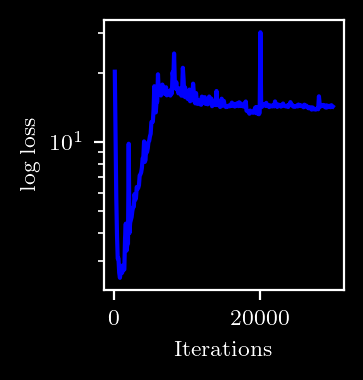

In [46]:
from IPython.display import Image, display
display(Image(filename='phys_surr_3d/log_plot.png',width=300))

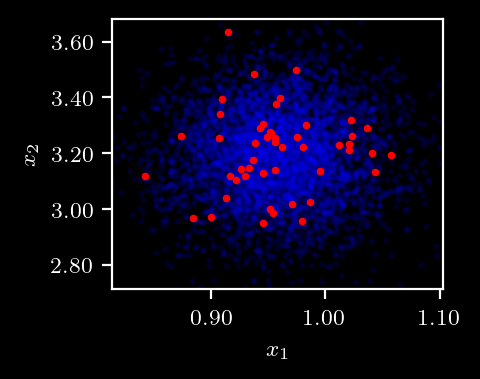

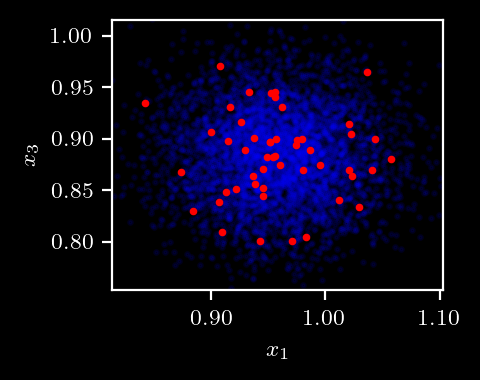

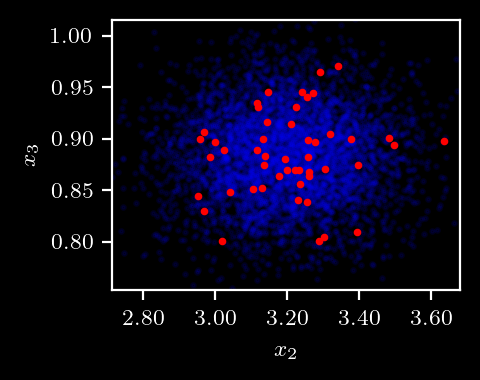

In [47]:
from IPython.display import Image, display
display(Image(filename='phys_surr_3d/data_plot_phys_surr_3d_30000_0_1.png',width=300))
display(Image(filename='phys_surr_3d/data_plot_phys_surr_3d_30000_0_2.png',width=300))
display(Image(filename='phys_surr_3d/data_plot_phys_surr_3d_30000_1_2.png',width=300))

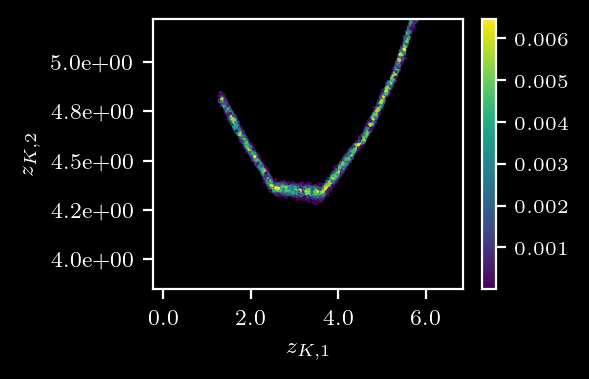

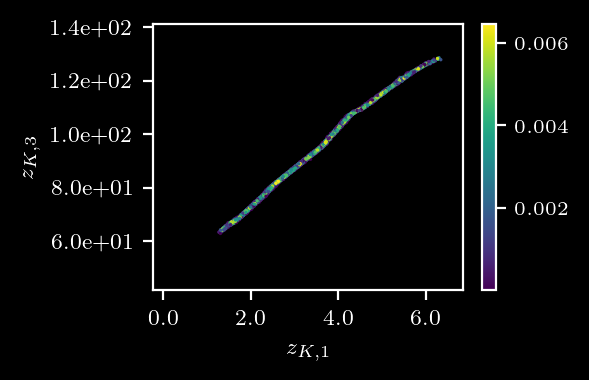

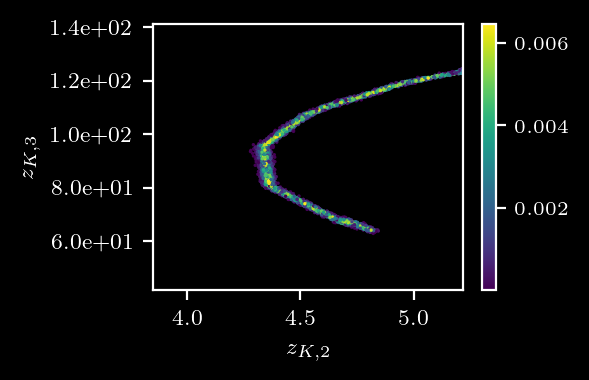

In [48]:
from IPython.display import Image, display
display(Image(filename='phys_surr_3d/params_plot_phys_surr_3d_30000_0_1.png',width=300))
display(Image(filename='phys_surr_3d/params_plot_phys_surr_3d_30000_0_2.png',width=300))
display(Image(filename='phys_surr_3d/params_plot_phys_surr_3d_30000_1_2.png',width=300))